In [ ]:
#neural networks model

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
import os

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class PricePredictionDataset(Dataset):
    """Price Prediction dataset."""

    def __init__(self, csv_file, transform):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.price_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.price_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = (self.price_frame.iloc[idx, 0])
        landmarks = self.price_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float')
        sample = {'image': img_name, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# set batch size
batch_size = 32

# load training data
X = pd.read_csv("train.csv")
Y = pd.read_csv("test.csv")

train_data = X.iloc[:, :-1]
train_data = train_data.drop("id", axis = 1)
train_data = train_data.fillna(train_data.mean())
train_label = X.iloc[:, -1]

test_data = Y.fillna(Y.mean())
test_id = Y["id"]
test_data = test_data.drop("id", axis = 1)

train_tensor = torch.tensor(train_data.values)
test_tensor = torch.tensor(test_data.values)

training_data = PricePredictionDataset(csv_file='train.csv', transform = None)
testing_data = PricePredictionDataset(csv_file='test.csv', transform = None)

In [ ]:

training_data_loader = torch.utils.data.DataLoader(training_data,
                                                  batch_size=batch_size,
                                                  shuffle=True)

# load test data
test_data_loader = torch.utils.data.DataLoader(testing_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

In [ ]:
# look at the number of batches per epoch for training and validation
print(f'{len(training_data_loader)} training batches')
print(f'{len(training_data_loader) * batch_size} training samples')
print(f'{len(test_data_loader)} validation batches')

18512 training batches
592384 training samples
5996 validation batches


In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25*16, 64),
        nn.ReLU(),
        nn.Dropout(.1),
        nn.Linear(64, 10)
        # PyTorch implementation of cross-entropy loss includes softmax layer
    )

In [ ]:
# why don't we take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

torch.Size([64, 400])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [ ]:
# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

total params: 26314


In [ ]:
# For a multi-class classification problem
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Train the model for 10 epochs, iterating on the data in batches
n_epochs = 10

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(training_data_loader):
        images = data
        labels = train_label
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(training_data_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')

In [ ]:
####################

In [2]:
import xgboost as xgb

In [14]:
X = pd.read_csv("train.csv")
Y = pd.read_csv("test.csv")
test_id = Y["id"]
train_label = X.iloc[:, -1:]

In [ ]:
mod_train_input = pd.read_csv('mod_train_input_ratio_nan.csv')
mod_test_input = pd.read_csv('mod_test_input_ratio_nan.csv')
norm_train_input = (mod_train_input - mod_train_input.min())/(mod_train_input.max() - mod_train_input.min())
norm_train_input.to_csv('norm_train_input.csv', index=None)
norm_test_input = (mod_test_input - mod_test_input.min())/(mod_test_input.max() - mod_test_input.min())
norm_test_input.to_csv('norm_test_input.csv', index=None)

In [ ]:
########START###########

In [3]:
X = pd.read_csv("newly_trained.csv")
Y = pd.read_csv("newly_test.csv")
train_data = X.drop("id", axis = 1)

In [ ]:
def modelfit(alg, dtrain, labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, labels,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(labels, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#Choose all predictors except target & IDcols
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, new_df, train_label)

In [12]:
#dtrain = xgb.DMatrix(new_df, label=train_label)
model = xgb.XGBRegressor(max_depth = 3, learning_rate = .1, n_jobs = 4)

In [ ]:
param = {'max_depth': 3, 'eta': .1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [ ]:
evallist = [(new_df, 'train')]

In [42]:
num_round = 10
#bst = xgb.train(param, dtrain, num_round, evallist)
model.fit(train_data_new, train_label, eval_metric = 'auc')

[13:42:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [7]:
train_data_new = train_data_new.reindex(sorted(train_data_new.columns), axis=1)

In [8]:
train_data_new['tot_bid_ask_vol_diff'] = train_data_new['tot_bid_vol'] - train_data_new['tot_ask_vol']

In [9]:
cols = train_data_new.columns.tolist()
cols.insert(0, cols.pop(cols.index('last_price')))
cols.insert(0, cols.pop(cols.index('mid')))
train_data_new = train_data_new.reindex(columns= cols)
train_data_new['mid'] = (train_data_new['mid'] - train_data_new['mid'].min())/(train_data_new['mid'].max() - train_data_new['mid'].min())
train_data_new['last_price'] = (train_data_new['last_price'] - train_data_new['last_price'].min())/(train_data_new['last_price'].max() - train_data_new['last_price'].min())
train_data_new['open_closed_qty_diff'] = train_data_new['opened_position_qty '] - train_data_new['closed_position_qty']
# del train_data_new['opened_position_qty ']
# del train_data_new['closed_position_qty']

In [10]:
del train_data_new['closed_position_qty']
train_data_new

,mid,last_price,ask1tot,ask2tot,ask3tot,ask4tot,ask5tot,bid1tot,bid2tot,bid3tot,...,bid5tot,bid_ask1diff,d_open_interest,opened_position_qty,price_change,tot_ask_vol,tot_bid_vol,transacted_qty,tot_bid_ask_vol_diff,open_closed_qty_diff
0,0.100362,0.100066,23056.8,3843.4,3843.6,38438.0,7688.0,30739.2,3842.0,23050.8,...,23042.4,0.4,0,2.390106,0.2,20,35,103.0,15,0.0
1,0.102994,0.101382,3843.8,15376.0,15377.6,3844.6,49982.4,26901.0,23056.8,42266.4,...,23050.8,0.8,-43,6.000000,0.6,23,31,55.0,8,0.0
2,0.105956,0.105332,3844.8,61520.0,38454.0,15382.4,34612.2,11531.4,3843.6,15372.8,...,46113.6,1.0,-69,7.000000,0.3,40,41,84.0,1,0.0
3,0.102994,0.104674,7687.6,26908.0,3844.4,7689.2,42292.8,38430.0,49956.4,46108.8,...,15365.6,0.8,-30,3.000000,-0.4,23,41,37.0,18,0.0
4,0.102007,0.102699,3843.4,11532.0,3844.6,42292.8,57675.0,53799.2,46108.8,7684.0,...,15365.6,0.6,-35,3.000000,-0.1,31,34,41.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592375,0.981244,0.981567,8220.8,12335.4,41120.0,28785.4,28788.2,8220.4,8220.0,4109.4,...,8218.0,0.2,1,1.000000,0.1,29,10,2.0,-19,0.0
592376,0.981902,0.978934,12335.4,37008.0,28785.4,28788.2,20565.0,12327.6,8218.0,8217.2,...,20540.0,2.6,1,6.000000,1.1,31,18,11.0,-13,0.0
592377,0.981902,0.978934,12335.4,37008.0,28785.4,28788.2,20565.0,12327.6,8218.0,8217.2,...,20540.0,2.6,0,0.000000,1.1,31,18,0.0,-13,0.0
592378,0.981902,0.978934,12335.4,37008.0,28785.4,28788.2,20565.0,12327.6,8218.0,8217.2,...,20540.0,2.6,0,0.000000,1.1,31,18,0.0,-13,0.0


In [6]:
train_data_new = train_data.drop(["bid_ask{}diff".format(i) for i in range(2, 6)], axis=1)

In [15]:
model.fit(train_data_new, train_label, eval_metric = 'auc')

[15:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [136]:
model.score(train_data_new, train_label)

0.08320907534990463

In [19]:
Y = pd.read_csv("newly_test.csv")
test_data_new = Y.drop(["bid_ask{}diff".format(i) for i in range(2, 6)], axis=1)
test_data_new['tot_bid_ask_vol_diff'] = test_data_new['tot_bid_vol'] - test_data_new['tot_ask_vol']
test_data_new = test_data_new.reindex(sorted(test_data_new.columns), axis=1)
cols = test_data_new.columns.tolist()
cols.insert(0, cols.pop(cols.index('last_price')))
cols.insert(0, cols.pop(cols.index('mid')))
test_data_new = test_data_new.reindex(columns= cols)
test_data_new['mid'] = (test_data_new['mid'] - test_data_new['mid'].min())/(test_data_new['mid'].max() - test_data_new['mid'].min())
test_data_new['last_price'] = (test_data_new['last_price'] - test_data_new['last_price'].min())/(test_data_new['last_price'].max() - test_data_new['last_price'].min())
test_data_new['open_closed_qty_diff'] = test_data_new['opened_position_qty '] - test_data_new['closed_position_qty']
del test_data_new['closed_position_qty']

In [20]:
test_data_new = test_data_new.drop("id", axis=1)

In [16]:

test_data = Y
test_input = test_data.drop("id", axis = 1)
#test_data = fill_nan_open_close_qty(test_data)

In [141]:
model.score(train_data, train_label)

0.07365984241686785

In [112]:
sum(n > 0.5 for n in model.predict(train_data))

81078

In [ ]:
test_input['bid1_tot'] = test_input['bid1'] * test_input['bid1vol']
test_input['bid2_tot'] = test_input['bid2'] * test_input['bid2vol']
test_input['bid3_tot'] = test_input['bid3'] * test_input['bid3vol']
test_input['bid4_tot'] = test_input['bid4'] * test_input['bid4vol']
test_input['bid5_tot'] = test_input['bid5'] * test_input['bid5vol']

test_input['ask1_tot'] = test_input['ask1'] * test_input['ask1vol']
test_input['ask2_tot'] = test_input['ask2'] * test_input['ask2vol']
test_input['ask3_tot'] = test_input['ask3'] * test_input['ask3vol']
test_input['ask4_tot'] = test_input['ask4'] * test_input['ask4vol']
test_input['ask5_tot'] = test_input['ask5'] * test_input['ask5vol']

test_input['price_change'] = test_input['mid'] - test_input['last_price']

test_edited_df = test_input.iloc[:, [i for i in range(0, 6)] + [i for i in range(-11, 0)]]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
y_train = model.predict(new_df)

In [ ]:
y_train_df = pd.DataFrame(y_train)

In [ ]:
clf = LogisticRegression()
clf.fit(y_train_df, train_label)

/Users/Arushi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Arushi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(test_edited_df)
y_pred_df = pd.DataFrame(y_pred)
y_pred_pt2 = clf.predict(y_pred_df)

In [ ]:
data = {'id':test_id, 'Predicted':y_pred_pt2}
df = pd.DataFrame(data)
df.to_csv('xgb_comb_feat_logreg.csv', index = False)

In [ ]:
#dtest = xgb.DMatrix(test_edited_df)
#ypred = bst.predict(dtest)
y_pred = model.predict(test_data_new)
y_pred = y_pred.clip(0, 1)

In [ ]:
data = {'id':test_id, 'Predicted':y_pred}
df = pd.DataFrame(data)
df.to_csv('xgb_preproc_data_2.csv', index = False) #max depth: 3, eta: .1, XGBRegressor

In [ ]:
test_data = Y.fillna(Y.mean())
test_id = Y["id"]
test_data = test_data.drop("id", axis = 1)
test_data = fill_nan_open_close_qty(test_data)
dtest = xgb.DMatrix(test_data)

In [ ]:
ypred = bst.predict(dtest)

In [ ]:
data = {'id':test_id, 'Predicted':ypred}

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('xgb_2.csv') #max depth: 15, eta: 1

In [22]:
###################################

In [28]:
X = pd.read_csv("train.csv")
Y = pd.read_csv("test.csv")
test_id = Y["id"]
train_label = X.iloc[:, -1:]

In [29]:
X = pd.read_csv("newly_trained.csv")
Y = pd.read_csv("newly_test.csv")
train_data = X.drop("id", axis = 1)

In [30]:
model = xgb.XGBRegressor(max_depth = 3, learning_rate = .1, n_jobs = 4)

In [31]:
model.fit(train_data, train_label, eval_metric = 'auc')

[15:16:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [32]:
test_input = Y.drop("id", axis = 1)
y_pred = model.predict(test_input)
y_pred = y_pred.clip(0, 1)

In [48]:
feat_imp = pd.DataFrame({"values": model.feature_importances_, "name": train_data.columns})

In [50]:
feat_imp.sort_values(by = "values")

,values,name
2,0.000000,opened_position_qty
3,0.000000,closed_position_qty
17,0.003682,bid4tot
21,0.005270,ask5tot
1,0.005368,mid
18,0.005520,ask4tot
20,0.005650,bid5tot
14,0.005720,bid3tot
19,0.005952,bid_ask4diff
0,0.007086,last_price


In [34]:
model.feature_importances_

array([0.00708594, 0.00536792, 0.        , 0.        , 0.0959713 ,
       0.01593671, 0.01522323, 0.03785803, 0.1454573 , 0.35650846,
       0.06078303, 0.02280927, 0.02753589, 0.01751479, 0.00572036,
       0.00715783, 0.01124969, 0.00368174, 0.00552033, 0.00595231,
       0.00565047, 0.00527002, 0.01931355, 0.12243181], dtype=float32)

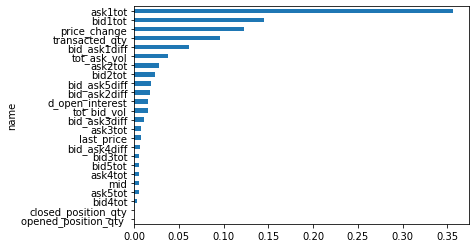

In [58]:
feat_imp.sort_values(by = "values").plot.barh(x="name", y="values", legend=False)

In [ ]:
#############

In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 15, num = 11)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
               }
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_depth': [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15, None]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(new_df, train_label)

In [30]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb_model = xgb.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid, n_iter = 40, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_data, train_label)

[05:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [ ]:
predicted_y = rf_random.predict(test_input)

In [ ]:
data = {'id':test_id, 'Predicted':predicted_y}
df = pd.DataFrame(data)
df.to_csv('/content/xgb_param_tuning_1.csv', index = False)

In [ ]:
########ADABOOST########

In [22]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier()
model_ada.fit(train_data, train_label.values.ravel())
ada_pred = model_ada.predict(test_input)

In [23]:
model_ada.score(train_data, train_label.values.ravel())

0.659770755258449

In [93]:
data = {'id':test_id, 'Predicted':ada_pred}
df = pd.DataFrame(data)
df.to_csv('adaboost.csv', index = False)

In [24]:
data = {'id':test_id, 'Predicted':predicted_y}
df = pd.DataFrame(data)
df.to_csv('/content/xgb_param_tuning_1.csv', index = False)

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
import lightgbm as lgb
training_data=lgb.Dataset(train_data,label=train_label)

In [ ]:
params = {'learning_rate':0.001}
model= lgb.train(params, training_data, 100)
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(y_pred,y_test)**0.5

In [ ]:
########LightGBM########

In [ ]:
#######STACKING###########

In [29]:
from sklearn.model_selection import KFold

In [32]:
# Some useful parameters which will come in handy later on
ntrain = train_data.shape[0]
ntest = test_input.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [45]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [95]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 300, 
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 10,
}
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':300,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 10,
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 200,
    'learning_rate' : 1
}

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

In [96]:
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)

In [50]:
y_train = train_label.values.ravel()
train = train_data
x_train = train_data.values # Creates an array of the train data
x_test = test_input.values # Creats an array of the test data

In [97]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 

In [ ]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print("hi")
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [98]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
#gb_feature = gb.feature_importances(x_train,y_train)

[0.         0.13306984 0.86693016]
[0.         0.13256076 0.86743924]
[nan nan nan]


/Users/Arushi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:263: RuntimeWarning:

invalid value encountered in true_divide



In [61]:
rf_features = [2.36488216e-03, 1.31019564e-03, 1.05337192e-02, 2.49929139e-02,
 4.95534822e-02, 6.12306275e-03, 1.57307705e-01, 5.04831431e-01,
 1.15813197e-02, 1.50790868e-02, 3.39450975e-04, 4.23898908e-04,
 9.77455790e-05, 2.27019932e-04, 1.17567308e-04, 3.73535406e-04,
 2.14742983e-01]
et_features = [0.04543154, 0.07366479, 0.03947251, 0.0259521,  0.04618256, 0.029027,
 0.17191218, 0.1995311,  0.05707797, 0.03299978, 0.00427576, 0.00368828,
 0.00411092, 0.00306996, 0.00547679, 0.00320922, 0.25491755]
ada_features = [0.01, 0.01, 0.01, 0.01, 0.11, 0.02, 0.2,  0.23, 0.03, 0.06, 0.02, 0.04, 0.02, 0.01,
 0.03, 0.01, 0.18]

In [62]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    })

In [63]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,mean
0,last_price,0.002365,0.045432,0.01,0.019265
1,mid,0.001310,0.073665,0.01,0.028325
2,opened_position_qty,0.010534,0.039473,0.01,0.020002


In [64]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


In [66]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [67]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [68]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test), axis=1)

In [73]:
gbm = xgb.XGBRegressor(
    #learning_rate = 0.02,
 n_estimators= 1000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [88]:
gbm.score(x_train, y_train)

0.02521488940998451

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# CV model
model = xgb.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, train_data, train_label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 65.25% (1.48%)


In [ ]:
cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.653018,0.000534,0.632289,0.000911
1,0.661982,0.000531,0.631532,0.000731
2,0.667132,0.001124,0.630554,0.000943
3,0.671619,0.002370,0.630168,0.001009
4,0.675781,0.002538,0.629803,0.001101
5,0.679568,0.001815,0.629250,0.000963
6,0.683326,0.001332,0.628819,0.000771
7,0.686911,0.001315,0.628662,0.000805
8,0.690158,0.001861,0.628164,0.000590
9,0.693030,0.002051,0.628025,0.000796


In [ ]:
model.fit(train_data, train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(test_data)

In [ ]:
data = {'id':test_id, 'Predicted':y_pred}
df = pd.DataFrame(data)
df.to_csv('xgb_3.csv')

In [ ]:
#############

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of 
    labels; this is the fraction of samples for which the labels differ.
    
    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """
    different = 0
    for i in range(len(y)):
      if y[i] != real_y.iloc[i]:
          different += 1
    return different/len(y)

In [ ]:
# load training data
X = pd.read_csv("train.csv")
Y = pd.read_csv("test.csv")

train_data = X.iloc[:, :-1]
train_data = train_data.drop("id", axis = 1)
train_data = train_data.fillna(train_data.mean())
train_label = X.iloc[:, -1]

test_data = Y.fillna(Y.mean())
test_id = Y["id"]
test_data = test_data.drop("id", axis = 1)

In [ ]:
train_data.shape

(592380, 26)

In [ ]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes= (2), random_state=1)

In [ ]:
clf.fit(train_data, train_label)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=2, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
predicted = clf.predict(train_data)
print(classification_err(predicted, train_label))

0.3569583713157095


In [ ]:
np.bincount(predicted)

array([592380])

In [ ]:
train_data

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,3842.4,3842.6,1.400583,1.964277,103.0,0,3842.4,3842.0,3841.8,3841.0,...,8,1,6,14,6,6,1,1,10,2
1,3842.8,3843.4,6.000000,49.000000,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,7,6,11,1,6,1,4,4,1,13
2,3844.0,3844.3,7.000000,77.000000,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,3,1,4,21,12,1,16,10,4,9
3,3843.8,3843.4,3.000000,34.000000,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,10,13,12,2,4,2,7,1,2,11
4,3843.2,3843.1,3.000000,38.000000,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,14,12,2,2,4,1,3,1,11,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592375,4110.2,4110.3,1.000000,1.000000,2.0,1,4110.2,4110.0,4109.4,4109.2,...,2,2,1,3,2,2,3,10,7,7
592376,4109.4,4110.5,6.000000,5.000000,11.0,1,4109.2,4109.0,4108.6,4108.2,...,3,2,2,6,5,3,9,7,7,5
592377,4109.4,4110.5,1.400583,1.964277,0.0,0,4109.2,4109.0,4108.6,4108.2,...,3,2,2,6,5,3,9,7,7,5
592378,4109.4,4110.5,1.400583,1.964277,0.0,0,4109.2,4109.0,4108.6,4108.2,...,3,2,2,6,5,3,9,7,7,5
